# SMS Spam Tespiti Projesi (GPT fine-tuning)

Bu projede, SMS mesajlarını "spam" ya da "ham" olarak sınıflandırmak için OpenAI’nin chat tabanlı fine-tuning yöntemini kullanacağız.

**Proje Adımları:**

1. Gerekli kütüphanelerin yüklenmesi  
2. Veri setinin (CSV) yüklenmesi ve keşif (EDA)  
3. Veri temizleme ve metin ön işleme  
4. CSV verisinin chat formatında JSONL dosyasına dönüştürülmesi  
5. JSONL dosyasının OpenAI API kullanılarak yüklenmesi  
6. Fine-tuning işinin başlatılması  
7. Fine-tuning işinin takibi ve modelin elde edilmesi  
8. Fine-tuned model ile tahmin yapılması  
9. Sonuçların değerlendirilmesi  

**Not:** Kullanacağımız model, chat formatı gerektiren **gpt-4o-mini-2024-07-18** gibi bir modeldir.


## Gerekli Kütüphanelerin Yüklenmesi
Aşağıdaki kod bloğunda, veri işleme, görselleştirme ve OpenAI API ile çalışmak için gerekli kütüphaneleri yüklüyoruz.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import time
import nltk

# nltk stopwords ve stemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# OpenAI API kütüphanesi
import os
import openai

# Ortam değişkeninden API anahtarını alıyoruz.
openai.api_key = os.getenv("OPENAI_API_KEY")

# API anahtarınız doğru şekilde yüklendiyse, artık API çağrıları yapabilirsiniz.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hakan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Veri Setinin Yüklenmesi ve Keşfi (EDA)

Elimizde `sms_spam_train.csv` adlı bir eğitim dosyası bulunuyor. İlk olarak dosyanın yapısını, ilk birkaç satırı ve etiket dağılımını inceleyelim.


,Message,Label
0,Whats upp ac enisteee: -) senin memlekette bul...,ham
1,"Kampanya, VakifBank Worldcardla 31 Mayisa kada...",spam
2,I wont. So wat's wit the guys,ham
3,Bu arada son dakika evi düşürdük,ham
4,No that just means you have a fat head,ham


Veri seti boyutu: (10000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Message  10000 non-null  object
 1   Label    10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB
None
Label
ham     6621
spam    3379
Name: count, dtype: int64


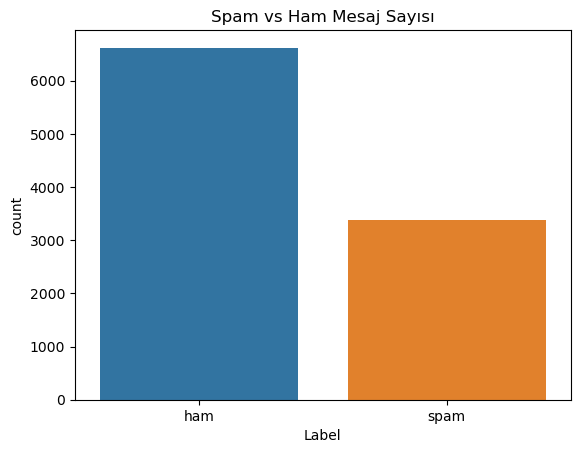

In [4]:
import os
from pathlib import Path
import pandas as pd


# Veri setinin okunması
base_dir = Path.cwd().parent  # Çalışma dizininin (notebooks) üst dizinine geçer.
dataset_path = base_dir / "datasets" / "sms_spam_train.csv"
df = pd.read_csv(dataset_path)

# İlk 5 satırı görüntüleyelim
display(df.head())

# Veri setinin boyutu ve sütun bilgileri
print("Veri seti boyutu:", df.shape)
print(df.info())

# Etiket dağılımını inceleyelim
print(df['Label'].value_counts())
sns.countplot(x='Label', data=df)
plt.title("Spam vs Ham Mesaj Sayısı")
plt.show()


## Veri Setinin Eğitim ve Doğrulama Olarak Ayırılması

Veriyi %80 eğitim, %20 doğrulama (validation) olarak ayıralım. Bu sayede fine-tuning sırasında eğitim ve validasyon performansını ayrı ayrı takip edebileceğiz.


In [9]:
from sklearn.model_selection import train_test_split


# Etiket dağılımını korumak için stratify kullanarak bölme
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

print("Eğitim seti boyutu:", train_df.shape)
print("Doğrulama seti boyutu:", valid_df.shape)


Eğitim seti boyutu: (8000, 3)
Doğrulama seti boyutu: (2000, 3)


## Veri Temizleme ve Metin Ön İşleme

Mesaj metinlerini küçük harfe çevirme, gereksiz karakterlerden arındırma, tokenization, stopwords kaldırma ve stemming uygulayarak temizleyelim.


In [10]:
# Eksik değer kontrolü (gerekirse)
train_df.dropna(inplace=True)
valid_df.dropna(inplace=True)

# Stemmer ve stopwords
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# İsteğe bağlı olarak temizlenmiş versiyonu da saklayabilirsiniz;
# Ancak burada asıl kullanım orijinal mesaj üzerinden olacak.
train_df['Cleaned_Message'] = train_df['Message'].apply(preprocess_text)
valid_df['Cleaned_Message'] = valid_df['Message'].apply(preprocess_text)

display(train_df[['Message', 'Cleaned_Message']].head())


,Message,Cleaned_Message
590,I don't run away frm u... I walk slowly &amp; ...,dont run away frm u walk slowli amp kill u don...
2526,U too...,u
1409,AYO download AXISnet dari Apple/Play Store dan...,ayo download axisnet dari appleplay store dan ...
8899,The whole car appreciated the last two! Dad an...,whole car appreci last two dad map read semi a...
5065,V-aluable. A-ffectionate. L-oveable. E-ternal....,valuabl affection loveabl etern nobl truth int...


## Eğitim Verisinin Chat Formatında JSONL Dosyasına Dönüştürülmesi

**Önemli:** Fine-tuning için kullanacağımız model, chat tabanlı olduğu için eğitim verilerinin de chat formatında olması gerekmektedir.  

Her bir eğitim örneğimizde aşağıdaki mesaj yapısını kullanacağız:

- **System Mesajı:** "You are an SMS spam detector." (Türkçeye çevirip "Sen bir SMS spam tespit sistemisin." şeklinde de kullanılabilir.)
- **User Mesajı:** SMS mesajı (örneğin, "Kampanya, VakifBank Worldcardla ...")
- **Assistant Mesajı:** Etiket ("spam" veya "ham")

Aşağıdaki kod, CSV dosyanızdaki her bir satırı bu formata dönüştürüp JSONL dosyasına yazacaktır.


In [11]:
def create_chat_jsonl(df, output_file):
    system_message = "Sen bir SMS spam tespit sistemisin."
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            example = {
                "messages": [
                    {"role": "system", "content": system_message},
                    {"role": "user", "content": row["Message"]},
                    {"role": "assistant", "content": row["Label"]}
                ]
            }
            f.write(json.dumps(example) + "\n")

# Eğitim ve validasyon JSONL dosyalarını oluşturma
train_jsonl = "sms_spam_finetune_train_chat.jsonl"
valid_jsonl = "sms_spam_finetune_valid_chat.jsonl"

create_chat_jsonl(train_df, train_jsonl)
create_chat_jsonl(valid_df, valid_jsonl)

print(f"Eğitim dosyası '{train_jsonl}' ve validasyon dosyası '{valid_jsonl}' oluşturuldu.")


Eğitim dosyası 'sms_spam_finetune_train_chat.jsonl' ve validasyon dosyası 'sms_spam_finetune_valid_chat.jsonl' oluşturuldu.


## JSONL Dosyasının OpenAI API ile Yüklenmesi

Oluşturduğumuz `sms_spam_finetune_chat.jsonl` dosyasını, fine-tuning amacıyla OpenAI dosya yükleme API’si kullanarak yükleyelim.


In [12]:
# Eğitim dosyasını yükleme
train_file_response = openai.File.create(
    file=open(train_jsonl, "rb"),
    purpose="fine-tune"
)
training_file_id = train_file_response.id
print("Eğitim dosyası yüklendi. Dosya ID'si:", training_file_id)

# Validasyon (doğrulama) dosyasını yükleme
valid_file_response = openai.File.create(
    file=open(valid_jsonl, "rb"),
    purpose="fine-tune"
)
validation_file_id = valid_file_response.id
print("Validasyon dosyası yüklendi. Dosya ID'si:", validation_file_id)


Eğitim dosyası yüklendi. Dosya ID'si: file-G4GWqpHUdNppGNZsN7ZmVs
Validasyon dosyası yüklendi. Dosya ID'si: file-P7phAyHghcVHiDGyp22e5h


In [13]:
fine_tune_job = openai.FineTuningJob.create(
    training_file=training_file_id,
    validation_file=validation_file_id,
    model="gpt-4o-mini-2024-07-18",  # Chat modeline uygun model
    method={
        "type": "supervised",
        "supervised": {
            "hyperparameters": {
                "n_epochs": 1,    # 1 epoch çalıştırarak toplam adım sayısını belirleyeceğiz
                "batch_size": 2   # Eğitim setindeki örnek sayısı / batch_size = adım sayısı (örneğin, 100/2 = 50 adım)
            }
        }
    }
)
print("Fine-tuning işi başlatıldı. İş ID'si:", fine_tune_job.id)


Fine-tuning işi başlatıldı. İş ID'si: ftjob-JeVmls5Ut4DLdNsPVccCYYEv


## Fine-Tuning İşinin Takibi ve Sonuçların Değerlendirilmesi

Fine-tuning işimiz başlatıldıktan sonra, belirli aralıklarla iş durumunu kontrol edip eğitim sürecinin ilerleyişini izleyelim.  
İş tamamlandıktan sonra, elde edilen fine-tuned modelin adını alacağız.


In [16]:
job_id = fine_tune_job.id

# İş durumunu kontrol etmek için döngü (örneğin, her 60 saniyede bir kontrol)
while True:
    job_status = openai.FineTuningJob.retrieve(job_id)
    print("İş durumu:", job_status.status)
    if job_status.status in ["succeeded", "failed", "cancelled"]:
        break
    time.sleep(30)

# İş tamamlandığında fine-tuned model adını alalım (başarılı ise)
fine_tuned_model = job_status.fine_tuned_model
print("Fine-tuned model adı:", fine_tuned_model)

# Son 10 olayı listeleyelim (job id'sini pozisyonel argüman olarak veriyoruz)
events = openai.FineTuningJob.list_events(job_id, limit=10)
for event in events.data:
    print(event.message)


İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: running
İş durumu: r

## Fine-Tuned Model ile Tahmin ve İnference

Fine-tuning işimiz tamamlandıktan sonra, elde ettiğimiz model ile yeni SMS mesajlarının sınıflandırmasını gerçekleştirelim.  
Aşağıdaki örnekte, bir test mesajı için modelden tahmin alacağız.


In [17]:
# Örnek test mesajı
test_message = "Kampanya, VakifBank Worldcardla 31 Mayisa kadar avantajlı teklif!"

# Chat completions endpoint’i kullanarak fine-tuned model ile tahmin yapıyoruz.
completion = openai.ChatCompletion.create(
    model=fine_tuned_model,  # Fine-tuning sonucu elde edilen model adı
    messages=[
        {"role": "system", "content": "Sen bir SMS spam tespit sistemisin."},
        {"role": "user", "content": test_message}
    ],
    temperature=0.0,
    max_tokens=10,
    stop=["\n"]
)

print("Tahmin Edilen Etiket:", completion.choices[0].message["content"])


Tahmin Edilen Etiket: spam


In [18]:
# Test (validasyon) veri setindeki her mesaj için fine-tune edilmiş modelin tahminini alıp, veri setine ekleyelim.

predicted_labels = []  # Tahmin edilen etiketleri saklamak için liste

# Test veri setindeki her bir satır için döngü oluşturuyoruz.
for idx, row in valid_df.iterrows():
    test_message = row["Message"]  # Orijinal mesajı kullanıyoruz
    try:
        # Modelden tahmin almak için ChatCompletion endpoint'i kullanıyoruz.
        completion = openai.ChatCompletion.create(
            model=fine_tuned_model,  # Fine-tune edilmiş modelin adı
            messages=[
                {"role": "system", "content": "Sen bir SMS spam tespit sistemisin."},
                {"role": "user", "content": test_message}
            ],
            temperature=0.0,
            max_tokens=10,
            stop=["\n"]
        )
        # Gelen cevabı (etiketi) alıyoruz ve başındaki/sonundaki boşlukları temizliyoruz.
        predicted_label = completion.choices[0].message["content"].strip()
    except Exception as e:
        print(f"Mesaj ID {idx} için hata oluştu: {e}")
        predicted_label = "error"
    predicted_labels.append(predicted_label)

# Test veri setine "Predicted_Label" sütunu olarak ekliyoruz.
valid_df["Predicted_Label"] = predicted_labels

# İlk birkaç satırı görüntüleyelim.
display(valid_df.head())


,Message,Label,Cleaned_Message,Predicted_Label
7128,"NAGAMAS ELECKTRONIK BB Dakota>2,4jt BB Davis>9...",spam,nagama elecktronik bb dakotajt bb davisrb bb g...,spam
3689,"Alright we'll bring it to you, see you in like...",ham,alright well bring see like ltgt min,ham
3290,Did u receive my msg?,ham,u receiv msg,ham
8931,Blue Card'a ozel %25 indirim firsati www.engli...,spam,blue carda ozel indirim firsati wwwenglishhome...,spam
8996,DUYURU: FIRSAT DEVAM EDIYOR. SEKIZ.COM DA TUM ...,spam,duyuru firsat devam ediyor sekizcom da tum tis...,spam


Confusion Matrix:
[[1309   15]
 [   4  672]]


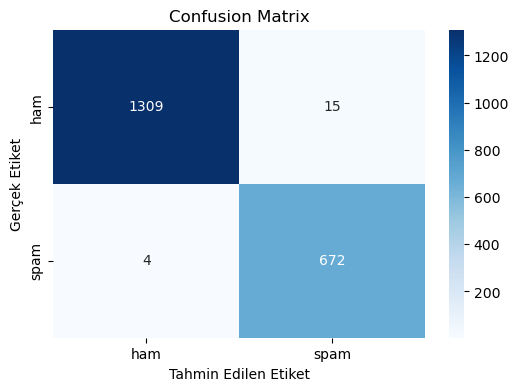

Classification Report:
              precision    recall  f1-score   support

         ham       1.00      0.99      0.99      1324
        spam       0.98      0.99      0.99       676

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Accuracy: 0.99
Precision (spam): 0.98
Recall (spam): 0.99
F1 Score (spam): 0.99


In [19]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Gerçek ve tahmin edilen etiketleri alalım
y_true = valid_df["Label"]
y_pred = valid_df["Predicted_Label"]

# Confusion matrix hesaplama (etiket sıralamasını belirleyerek)
labels = sorted(y_true.unique())  # Örneğin, ["ham", "spam"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Confusion matrix'i yazdırma
print("Confusion Matrix:")
print(cm)

# Confusion matrix'in görselleştirilmesi
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.title("Confusion Matrix")
plt.show()

# Classification report hesaplama
report = classification_report(y_true, y_pred, target_names=labels)
print("Classification Report:")
print(report)

# Ek metrikleri hesaplayalım
accuracy = accuracy_score(y_true, y_pred)
# Pozitif sınıfı "spam" olarak alalım (örneğin, spam olan mesajlara odaklanıyoruz)
precision = precision_score(y_true, y_pred, pos_label="spam")
recall = recall_score(y_true, y_pred, pos_label="spam")
f1 = f1_score(y_true, y_pred, pos_label="spam")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (spam): {precision:.2f}")
print(f"Recall (spam): {recall:.2f}")
print(f"F1 Score (spam): {f1:.2f}")


LLM supervised fine-tuning yönteminin, klasik machine learning classification yöntemine göre çok daha başarılı olduğunu görüyoruz.